In [1]:
from __future__ import absolute_import, division, print_function

%matplotlib inline

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'
import numpy as np
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../')

import tensorflow as tf
import seaborn as sns
import saliency
import pickle
import PIL
import json

# urllib python2 v. python3 hack.
if sys.version_info[0] == 3:
    from urllib.request import urlopen
else:
    from urllib import urlopen

from matplotlib import gridspec
import seaborn as sns

from scipy.stats import spearmanr as spr
from scipy.stats import pearsonr
import pandas as pd
# from skimage.measure import compare_ssim as ssim
from skimage import measure

from skimage import feature
slim=tf.contrib.slim

from src.inception_v3 import inception_v3_arg_scope
from src.inception_v3 import inception_v3

# some plotting defaults
%matplotlib inline
sns.set_style('whitegrid', {'axes.grid': False})
SSIZE=10
MSIZE=12
BSIZE=14
plt.rc('font', size=SSIZE)
plt.rc('axes', titlesize=MSIZE)
plt.rc('axes', labelsize=MSIZE)
plt.rc('xtick', labelsize=MSIZE)
plt.rc('ytick', labelsize=MSIZE)
plt.rc('legend', fontsize=MSIZE)
plt.rc('figure', titlesize=MSIZE)
plt.rcParams['font.family'] = "sans-serif"

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.




In [2]:
def abs_grayscale_norm(img):
    """Returns absolute value normalized image 2D."""
    assert isinstance(img, np.ndarray), "img should be a numpy array"
    
    shp = img.shape
    if len(shp)< 2:
        raise ValueError("Array should have 2 or 3 dims!")
    if len(shp)==2:
        img = np.absolute(img)
        img = img/float(img.max())
    else:
        img = saliency.core.VisualizeImageGrayscale(img)
    return img
def diverging_norm(img):
    """Returns image with positive and negative values."""
    assert isinstance(img, np.ndarray), "img should be a numpy array"
    
    shp = img.shape
    if len(shp)< 2:
        raise ValueError("Array should have 2 or 3 dims!")
    if len(shp)==2:
        imgmax = np.absolute(img).max()
        img = img/float(imgmax)
    else:
        img = saliency.core.VisualizeImageDiverging(img)
    return img

def plot_single_img(img,
                    ax=False,
                    norm=diverging_norm,
                    show_axis=False,
                    grayscale=False,
                    cmap='gray',
                    title='',
                    fig_size=(4,4)):
    plt.figure(figsize=fig_size)
    if norm:
        img = norm(img)
    if not show_axis:
        plt.axis('off')
    plt.imshow(img, cmap=cmap)
    if title:
        plt.title(title)

def LoadImage(file_path, resize=True, sztple=(299, 299)):
    img = PIL.Image.open(file_path).convert('RGB')
    if resize:
        img = img.resize(sztple, PIL.Image.ANTIALIAS)
    img = np.asarray(img)
    return img / 127.5 - 1.0

def ShowImage(im, title='', ax=None):
    if ax is None:
        plt.figure()
    plt.axis('off')
    im = ((im + 1) * 127.5).astype(np.uint8)
    plt.imshow(im)
    plt.title(title)
    
def normalize_image(x):
    x = np.array(x).astype(np.float32)
    x_min = x.min()
    x_max = x.max()
    x_norm = (x - x_min) / (x_max - x_min)
    return x_norm

In [3]:
def get_saliency_constructors(model_graph,
                              model_session,
                              logit_tensor,
                              input_tensor,
                              gradcam=False,
                              conv_layer_gradcam=None):
    """Initialize mask functions in saliency package.

    Args:
        model_graph: tf graph of the model.
        model_session: tf session with trained model loaded.
        logit_tensor: tensor corresponding to the model logit output.
        input_tensor: tensor coresponding to the input data.
        gradcam: boolean to indicate whether to include gradcam.
        conv_layer_gradcam: tensor corresponding to activations
                            from a conv layer, from the trained model.
                            Authors recommend last layer.
    Returns:
        saliency_constructor: dictionary (name of method, and value is
                              function to each saliency method.
        neuron_selector: tensor of specific output to explain.
    """

    assert (type(tf.Graph()) == type(model_graph)),\
        ("Model graph should be of type {}".format(type(tf.Graph())))

    if gradcam and conv_layer_gradcam is None:
        raise ValueError("If gradcam is True, then conv_layer_gradcam"
                         "is be provided.")
    with model_graph.as_default():
        with tf.name_scope("saliency"):
            neuron_selector = tf.placeholder(tf.int32)
            y_salient = logit_tensor[neuron_selector]
    gradient_saliency = saliency.tf1.GradientSaliency(model_graph,
                                                  model_session,
                                                  y_salient,
                                                  input_tensor)
    guided_backprop = saliency.tf1.GuidedBackprop(model_graph,
                                              model_session,
                                              y_salient,
                                              input_tensor)
    integrated_gradients = saliency.tf1.IntegratedGradients(model_graph,
                                                        model_session,
                                                        y_salient,
                                                        input_tensor)
    saliency_constructor = {'vng': gradient_saliency,
                            'gbp': guided_backprop,
                            'ig': integrated_gradients}
    if gradcam:
        gradcam = saliency.tf1.GradCam(model_graph,
                                   model_session,
                                   y_salient,
                                   input_tensor,
                                   conv_layer_gradcam)
        saliency_constructor['gc'] = gradcam
    return saliency_constructor, neuron_selector

# Wrapper for Inception-v3 model

In [4]:
class Inceptionv3_Wrapper(object):
    def __init__(self, checkpointpath, labelmetadatapath):
        tf.compat.v1.reset_default_graph()
        self.graph = tf.Graph()
        self.chkpntpath = checkpointpath
        self.labelmetadatapath = labelmetadatapath
        self.num_classes = 1001 # 0 is background or null class
        self.label_dict = {}
        
        if not tf.io.gfile.exists(self.chkpntpath):
            raise ValueError("There is no checkpoint at the input path")
        with self.graph.as_default():
            self.input_batch = tf.placeholder(tf.float32,
                                          shape=(None, 299, 299, 3))
            with slim.arg_scope(inception_v3_arg_scope()):
                _, self.end_points = inception_v3(
                  self.input_batch,
                  is_training=False,
                  num_classes=self.num_classes)
                self.session = tf.Session(graph=self.graph)
                self.saver = tf.train.Saver()
                self.saver.restore(self.session, self.chkpntpath)
                
            self.logits = self.graph.get_tensor_by_name(
                'InceptionV3/Logits/SpatialSqueeze:0')
            self.trainable_variables = tf.trainable_variables()
        
        if not tf.io.gfile.exists(self.labelmetadatapath):
            raise ValueError("There is no label file at the input path.")
        
        # process labels in appropriate dictionary
        with open(self.labelmetadatapath) as json_file:
            data = json.load(json_file)
            shift = 0
            if self.num_classes == 1001:
                self.label_dict = {0: ["background", "background"]}
                shift = 1
            for key in data:
                self.label_dict[int(key)+shift] = data[key] 
        
    def predict(self, batch):
        if not isinstance(batch, (np.ndarray)):
            raise ValueError("input should be a numpy array!")
        
        if len(batch.shape) < 4:
            raise ValueError(
              "Shape should be (nsamples, height, width, channels)")
        
        feed_dict = {self.input_batch: batch}
        logits = self.session.run(self.logits,
                                  feed_dict = feed_dict)
        return logits
    
    def reinitlayerlist(self, blocklist, independent=False):
        """Reinitialize Tensors with these names."""
        if independent:
            self.__init__()
        tensors = []
        for op in self.trainable_variables:
            for blockname in blocklist:
                if blockname in op.name:
                    tensors.append(op)
                    
        # now reinitialize
        with self.graph.as_default():
            to_ini = tf.initialize_variables(tensors)
            _ = self.session.run(to_ini)
        return True
        
    def indextoclsnames(self, arr, topk=5):
        """Given a numpy vector, get label names for topk."""
        names = []
        topk_indices = arr.argsort()[::-1][:topk]
        for val in topk_indices:
            names.append(self.label_dict[val][1])
        return names

In [5]:
cwd = os.getcwd()
imagenetlabeljsonpath = '../models/inceptionv3/imagenet_class_index.json'
chkpntpath = '../models/inceptionv3/inception_v3.ckpt'
chkpntpath = os.path.join(cwd, chkpntpath)
imagenetlabeljsonpath = os.path.join(cwd, imagenetlabeljsonpath)
if not os.path.exists(chkpntpath):
    raise ValueError("Checkpoint path does not exist!")
if not os.path.exists(imagenetlabeljsonpath):
    raise ValueError("Label json path does not exist!")

# Load inception model and test predictions

In [6]:
inception_model = Inceptionv3_Wrapper(chkpntpath, imagenetlabeljsonpath)


Instructions for updating:
Please use `layer.__call__` method instead.


INFO:tensorflow:Restoring parameters from /home/liilu/Desktop/COURSE/ImageProcessing/Assignment2/BASELINE/sanity_checks_saliency/notebooks/../models/inceptionv3/inception_v3.ckpt


# Let's compute saliency maps for this image

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.misc import face
from scipy.ndimage import zoom
from scipy.special import logsumexp
import torch
from PIL import Image
import pysaliency
DEVICE = 'cuda'



def run_metrics(model: pysaliency.SaliencyMapModel , mit_stimuli, mit_fixations, cutoff=10):
	print(mit_stimuli.filenames[:cutoff])
	short_stimuli = pysaliency.FileStimuli(filenames=mit_stimuli.filenames[:cutoff])
	short_fixations = mit_fixations[mit_fixations.n < cutoff]
	auc_uniform = model.AUC(short_stimuli, short_fixations, nonfixations='uniform', verbose=True)
	auc_shuffled = model.AUC(short_stimuli, short_fixations, nonfixations='shuffled', verbose=True)
	auc_identical_nonfixations = model.AUC(short_stimuli, short_fixations, nonfixations=short_fixations, verbose=True)
	kl_uniform = model.fixation_based_KL_divergence(short_stimuli, short_fixations, nonfixations='uniform')
	kl_shuffled = model.fixation_based_KL_divergence(short_stimuli, short_fixations, nonfixations='shuffled')
	kl_identical = model.fixation_based_KL_divergence(short_stimuli, short_fixations, nonfixations=short_fixations)
	gold_standard = pysaliency.FixationMap(short_stimuli, short_fixations, kernel_size=30)
	image_based_kl = model.image_based_kl_divergence(short_stimuli, gold_standard)

	return auc_uniform, auc_shuffled, auc_identical_nonfixations, kl_uniform, kl_shuffled, kl_identical, image_based_kl
  
class SanityChecksSaliencyModel(pysaliency.SaliencyMapModel):
	
	def __init__(self, method: str, **kwargs):
		super().__init__()
		# set up saliency computations.
		assert method in ['Gradient', 'SmoothGrad', 'Guided\nBackProp', 'Integrated\nGradients', 'IG\nSmoothGrad', 'GradCAM']
		self.saliency_dict, self.n_selector = get_saliency_constructors(inception_model.graph,
															inception_model.session,
															inception_model.logits[0],
															inception_model.input_batch,
															gradcam=True,
															conv_layer_gradcam=inception_model.end_points['Mixed_7c'])

		# these are the methods we will look at
		self.saliency_methods = {'Gradient': self.saliency_dict['vng'].GetMask,
							'SmoothGrad': self.saliency_dict['vng'].GetSmoothedMask,
							'Guided\nBackProp': self.saliency_dict['gbp'].GetMask,
							'Integrated\nGradients': self.saliency_dict['ig'].GetMask,
							'IG\nSmoothGrad': self.saliency_dict['ig'].GetSmoothedMask,
							'GradCAM': self.saliency_dict['gc'].GetMask}
		self.saliency_method = method
		assert self.saliency_method in self.saliency_methods.keys(), "Method not in {}".format(self.saliency_methods.keys())
		gen_feed_dict = {}
		baseline = np.zeros((299, 299, 3))
		self.saliency_params = {'Gradient': {"feed_dict": gen_feed_dict},
						'SmoothGrad': {"feed_dict": gen_feed_dict,
										"stdev_spread":0.15,
										"nsamples":50,
										"magnitude":False},
						'Guided\nBackProp': {"feed_dict": gen_feed_dict},
						'Integrated\nGradients': {"feed_dict": gen_feed_dict,
													"x_steps":50,
													"x_baseline":baseline},
						'IG\nSmoothGrad': {"feed_dict": gen_feed_dict,
											"x_steps":50,
											"stdev_spread": 0.15,
											"x_baseline":baseline,
											"magnitude":False},
						'GradCAM':{"feed_dict": gen_feed_dict,
									"three_dims": True}}    
		
		
	def _saliency_map(self, stimulus):
		# print("The input stimulus is ...")
		# print(stimulus.shape, stimulus.dtype, np.min(stimulus), np.max(stimulus))
		
		og_shape = stimulus.shape
		# print(f"the og_shape is {og_shape}")
		current_image = Image.fromarray(np.uint8(stimulus)).convert("RGB")
		sztple = (299, 299)
		current_image = current_image.resize(sztple, PIL.Image.ANTIALIAS)
		current_image = np.asarray(current_image)
		current_image = current_image / 127.5 - 1.0
		
		baseline = np.zeros(current_image.shape)
		imglogits = inception_model.session.run(
			[inception_model.logits],
			feed_dict={inception_model.input_batch: np.expand_dims(current_image, 0)})[0]
		
		prediction_class = imglogits.argmax() # compute saliency for top class.
		gen_feed_dict = {self.n_selector: prediction_class}
		self.saliency_params[self.saliency_method]['feed_dict'] = gen_feed_dict
		if "x_baseline" in self.saliency_params[self.saliency_method]:
			self.saliency_params[self.saliency_method]['x_baseline'] = baseline
			
		output_masks = {}
		key = self.saliency_method
		# print("On {}".format(key))
		params = self.saliency_params[key]
		output_masks[key] = self.saliency_methods[key](current_image,**params)
		output = output_masks[self.saliency_method]
		# print(output.shape, output.dtype, np.min(output), np.max(output))
		# plt.imshow(output)
		# plt.show()
		
		# output = Image.fromarray(np.uint8(output)).convert("RGB")
		# output = output.resize(og_shape[:2], PIL.Image.ANTIALIAS)
		# output = np.asarray(output)

		# print(output.shape, output.dtype, np.min(output), np.max(output))
		return output
	
dataset_location = "../../datasets/"
mit_stimuli, mit_fixations = pysaliency.external_datasets.get_mit1003(location=dataset_location)

model_zoo = ['Gradient', 'SmoothGrad', 'Guided\nBackProp', 'Integrated\nGradients', 'IG\nSmoothGrad', 'GradCAM']
model_instances = []

for model_name in model_zoo:
	model = SanityChecksSaliencyModel(method=model_name)
	model_instances.append(model)

cut_off = 10
overall_list_of_masks = []
for stimuli in mit_stimuli[0:cut_off]:
	list_of_masks = []
	for model in model_instances:
		smap = model.saliency_map(stimuli)
		list_of_masks.append(smap)
	overall_list_of_masks.append(list_of_masks)


INFO:tensorflow:Restoring parameters from /tmp/guided_backprop_ckpt
INFO:tensorflow:Restoring parameters from /tmp/guided_backprop_ckpt
INFO:tensorflow:Restoring parameters from /tmp/guided_backprop_ckpt
INFO:tensorflow:Restoring parameters from /tmp/guided_backprop_ckpt
INFO:tensorflow:Restoring parameters from /tmp/guided_backprop_ckpt
INFO:tensorflow:Restoring parameters from /tmp/guided_backprop_ckpt


In [8]:
overall_list_of_masks_abs_norm = []
overall_list_of_masks_no_abs_norm = []
overall_list_of_masks_0_1_norm = []

print(overall_list_of_masks)

for idx, list_of_masks in enumerate(overall_list_of_masks):
    for i, img_dict in enumerate(list_of_masks):
        
        list_of_masks_abs_norm = []
        list_of_masks_no_abs_norm = []
        list_of_masks_0_1_norm = []

        new_dict_abs_norm = {}
        new_dict_no_abs_norm = {}
        new_dict_0_1_norm = {}
        
        for key in img_dict:
            mask = img_dict[key]
            mask_abs_norm = abs_grayscale_norm(mask)
            mask_no_abs_norm = diverging_norm(mask)
            mask_0_1_norm = normalize_image(mask)
            new_dict_abs_norm[key] = mask_abs_norm
            new_dict_no_abs_norm[key] = mask_no_abs_norm
            new_dict_0_1_norm[key] =mask_0_1_norm
            
        list_of_masks_abs_norm.append(new_dict_abs_norm)
        list_of_masks_no_abs_norm.append(new_dict_no_abs_norm)
        list_of_masks_0_1_norm.append(new_dict_0_1_norm)
        
    overall_list_of_masks_abs_norm.append(list_of_masks_abs_norm)
    overall_list_of_masks_no_abs_norm.append(list_of_masks_no_abs_norm)
    overall_list_of_masks_0_1_norm.append(list_of_masks_0_1_norm)
    

[[array([[[ 6.88144646e-05, -1.50098385e-05, -2.14925109e-04],
        [ 2.30527759e-04,  7.12735491e-05, -2.98573781e-04],
        [ 6.64607156e-04,  4.43011872e-04, -2.78563413e-04],
        ...,
        [ 1.72648497e-03, -8.19028704e-04, -6.43334177e-04],
        [-3.89099936e-04, -4.03138518e-04,  6.76637050e-04],
        [-1.61537653e-04,  1.57311326e-04,  6.04476547e-04]],

       [[ 9.47227672e-05, -2.18924761e-04, -3.83744395e-04],
        [ 4.59348870e-04, -1.89994553e-05, -6.02496031e-04],
        [ 8.27837503e-04,  3.81957507e-05, -5.53137972e-04],
        ...,
        [-2.05246639e-03, -3.66632803e-03, -1.45192060e-03],
        [-1.05776230e-03, -1.88705383e-03,  6.26041379e-04],
        [ 5.46741474e-04, -1.38517789e-04,  8.41914676e-04]],

       [[ 3.16130201e-04, -1.17620002e-05, -2.31787868e-04],
        [ 6.30399212e-04, -4.71487758e-04, -1.12251600e-03],
        [ 3.18955863e-05,  1.45965512e-03,  7.77548703e-04],
        ...,
        [-3.91145842e-03, -3.88918282e-0

IndexError: arrays used as indices must be of integer (or boolean) type

# Visualize Maps

In [ ]:
# combine all the images to be plotted into one long list
# format is [(input, mask1, mask2, etc)]
mask_order = ["Gradient", "SmoothGrad","Input-Grad", "Guided\nBackProp",\
              "GradCAM", "GBP-GC", "Integrated\nGradients", "IG\nSmoothGrad"]

overall_master_mask_list_abs_norm = []
overall_master_mask_list_no_abs_norm = []

for idx, (list_of_masks_abs_norm, list_of_masks_no_abs_norm, _) in enumerate(zip(overall_list_of_masks_abs_norm, overall_list_of_masks_no_abs_norm, overall_list_of_masks_0_1_norm)):
    master_mask_list_abs_norm = []
    master_mask_list_no_abs_norm = []
    for i, (img_dict_abs_norm, img_dict_no_abs_norm) in enumerate(zip(list_of_masks_abs_norm,
                                                                    list_of_masks_no_abs_norm)):
        # first append original image
        og_img = mit_stimuli[:cut_off][i]
        master_mask_list_abs_norm.append(og_img)
        master_mask_list_no_abs_norm.append(og_img)
        
        # loop through dicts to append each mask type
        for mask_type in mask_order:
            master_mask_list_abs_norm.append(img_dict_abs_norm[mask_type])
            master_mask_list_no_abs_norm.append(img_dict_no_abs_norm[mask_type])
            
    overall_master_mask_list_abs_norm.append(master_mask_list_abs_norm)
    overall_master_mask_list_no_abs_norm.append(master_mask_list_no_abs_norm)
    

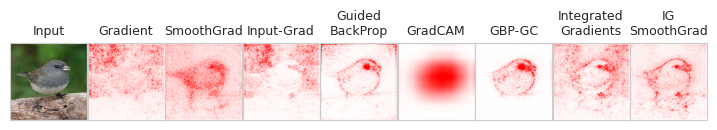

In [ ]:
nrows, ncols = len(model_instances), cut_off
fig = plt.figure(figsize=(model_instances, cut_off))
gs = gridspec.GridSpec(nrows, ncols,
                       wspace=0.0, hspace=0.0)
cmap='bwr'
count = 0
titles = model_zoo
for i in range(nrows):
    
    master_mask_list_no_abs_norm = overall_master_mask_list_no_abs_norm[i]
    master_mask_list_abs_norm = overall_master_mask_list_abs_norm[i]

    for j in range(ncols):
        ax = plt.subplot(gs[i, j])
        if (count==0) or (count%len(model_instances)==0):
            img = ((master_mask_list_abs_norm[count] + 1) * 127.5).astype(np.uint8)
            ax.imshow(img)
            ax.set_xticklabels([])
            ax.set_yticklabels([])
        else:
            ax.imshow(master_mask_list_abs_norm[count],
                      vmin=-1.0,
                      vmax=1.0,
                      cmap=cmap)
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            
        # add labels
        if count < len(model_instances):
            ax.set_title(titles[count], fontsize=9)
        count +=1
plt.show()